In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB5
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
import collections
import random
from PIL import Image

# Global Parameters

In [ ]:
img_size = 456  # Image size (EfficientNetB5 requires 456x456 images)
batch_size = 16  # Number of images processed at once during training
epochs = 10  # Number of training cycles

# Download Dataset from Kaggle

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("andrewmvd/isic-2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isic-2019


# Load Data

In [ ]:
base_dir = os.path.join(path, "ISIC_2019_Training_Input", "ISIC_2019_Training_Input")

groundtruth_path = os.path.join(path, "ISIC_2019_Training_GroundTruth.csv")
labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']  # The 8 skin disease classes
groundtruth = pd.read_csv(groundtruth_path)
groundtruth['label'] = groundtruth[labels].idxmax(axis=1)  # Convert one-hot labels into class names

file_paths = [os.path.join(base_dir, row['image'] + '.jpg') for _, row in groundtruth.iterrows()]
labels_indices = [labels.index(row['label']) for _, row in groundtruth.iterrows()]

print(f"Total number of images in the dataset: {len(file_paths)}")

Total number of images in the dataset: 25331


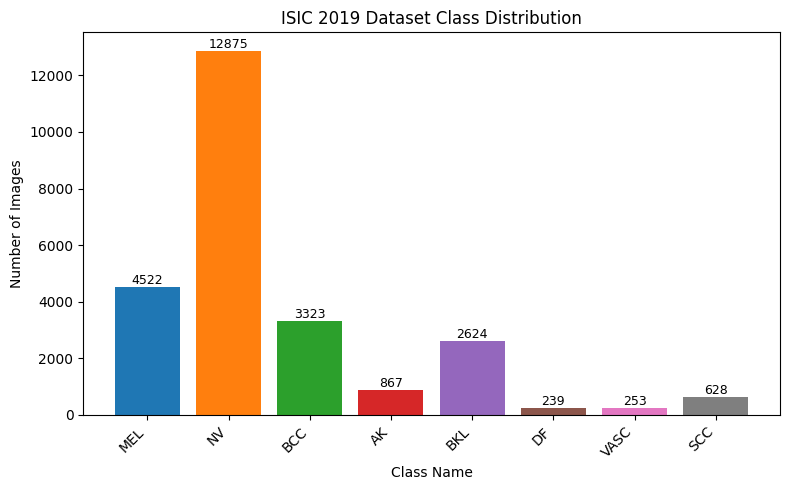

In [ ]:
label_counts = pd.Series(labels_indices).value_counts().sort_index()
label_names = [labels[i] for i in label_counts.index]

colors = plt.cm.tab10.colors

plt.figure(figsize=(8, 5))
bars = plt.bar(label_names, label_counts, color=colors[:len(label_names)])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('ISIC 2019 Dataset Class Distribution')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
             ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

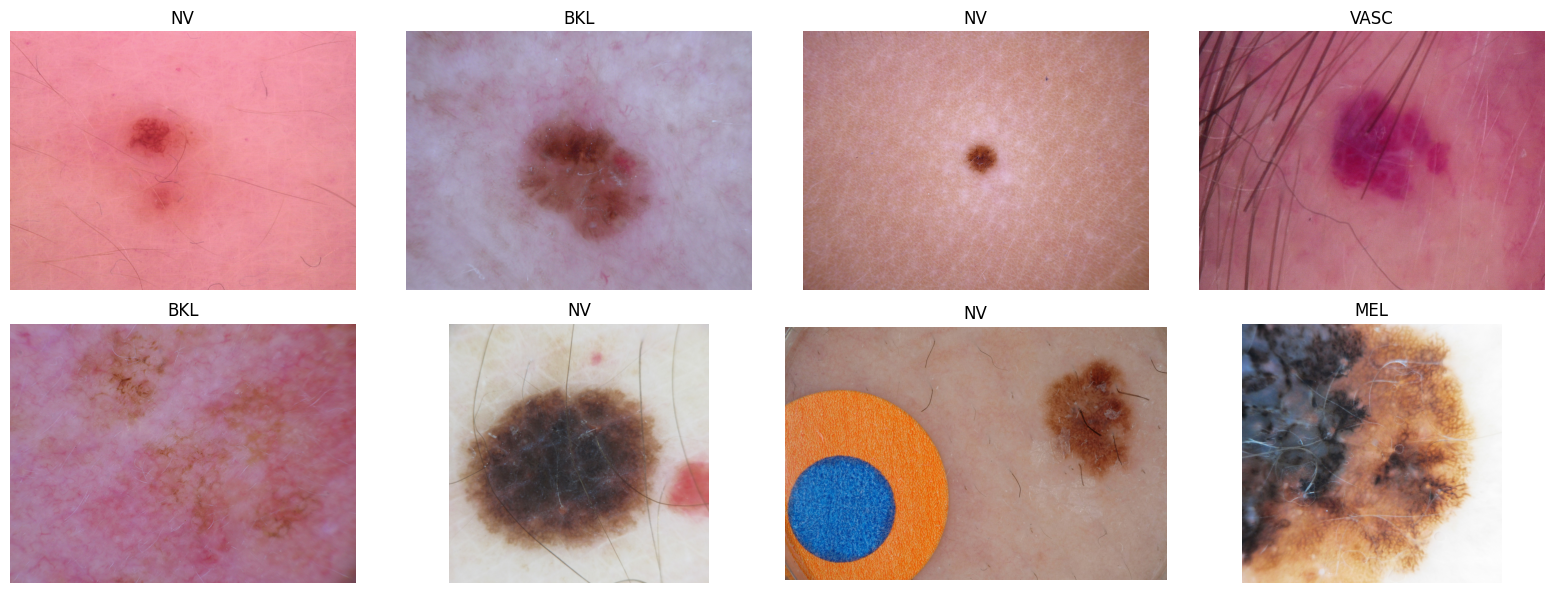

In [ ]:
num_samples = 8
sample_indices = random.sample(range(len(file_paths)), num_samples)

plt.figure(figsize=(16, 6))
for i, idx in enumerate(sample_indices):
    image = Image.open(file_paths[idx])
    label = labels_indices[idx]

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(labels[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Train Test Split

In [ ]:
# Split into train/test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels_indices, test_size=0.2, random_state=42
)

In [ ]:
print("Number of training images:", len(train_paths))
print("Number of test images:", len(test_paths))

Number of training images: 20264
Number of test images: 5067


# Preprocessing Images

In [ ]:
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

In [ ]:
# Apply augmentation on training dataset
def preprocess_and_augment(file_path, label):
    img, label = preprocess_image(file_path, label)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Handling Class Imbalance

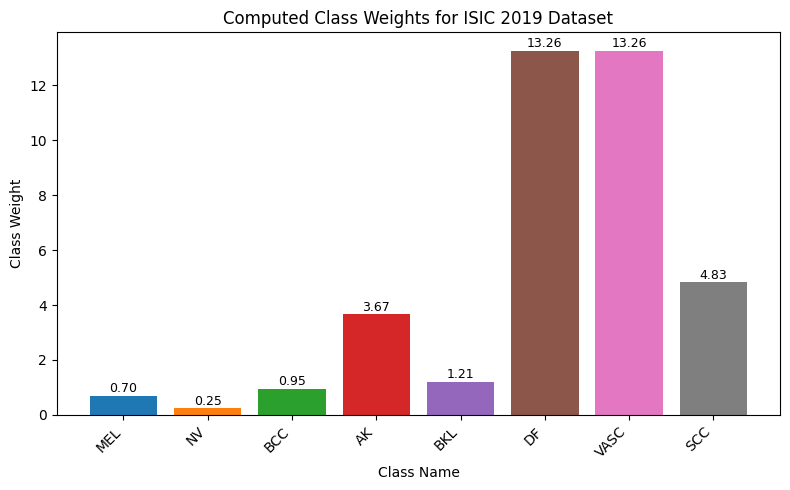

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Prepare data for plotting
label_names = [labels[i] for i in class_weights_dict.keys()]
weight_values = [class_weights_dict[i] for i in class_weights_dict.keys()]

colors = plt.cm.tab10.colors

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(label_names, weight_values, color=colors[:len(label_names)])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class Name')
plt.ylabel('Class Weight')
plt.title('Computed Class Weights for ISIC 2019 Dataset')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Building Custom EfficientNetB5 Model

In [ ]:
# EfficientNetB5 Model
base_model = EfficientNetB5(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.trainable = True
fine_tune_at = 300
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/models/final_model.keras"
#input_path = "/kaggle/input/final_model_skin_cancer/keras/default/4/final_model (3).keras"
#output_path = "/kaggle/working/final_model.keras"

In [ ]:
if os.path.exists(checkpoint_path):
    print("Loading model from checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("No checkpoint found. Initializing a new model...")
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(labels), activation="softmax")(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

Loading model from checkpoint...


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 456, 456, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 15, 15, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,748,553 (216.48 MB)

 Trainable params: 27,181,832 (103.69 MB)

 Non-trainable params: 2,384,887 (9.10 MB)

 Optimizer params: 27,181,834 (103.69 MB)

# Train Model

In [ ]:
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=output_path,
#     monitor="val_accuracy",
#     mode="max",
#     save_best_only=False,
#     verbose=1
# )

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=3,
#     restore_best_weights=True
# )

In [ ]:
# history = model.fit(
#     train_dataset,
#     validation_data=test_dataset,
#     epochs=epochs,
#     class_weight=class_weights_dict,
#     callbacks=[checkpoint_callback, early_stop]
# )


In [ ]:
# # Plot training and validation loss & accuracy
# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training vs Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training vs Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# Model Evaluation

In [ ]:
# Model evaluation on test set
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

317/317 ━━━━━━━━━━━━━━━━━━━━ 112s 272ms/step - accuracy: 0.8212 - loss: 0.6696
Test Accuracy: 0.8251
Test Loss: 0.6580


In [ ]:
# Classification report
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in test_dataset], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# Calculate metrics with .4f precision
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nTest Accuracy : {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall   : {recall:.4f}")
print(f"Test F1-score : {f1:.4f}")


Test Accuracy : 0.8251
Test Precision: 0.8410
Test Recall   : 0.8251
Test F1-score : 0.8294


In [ ]:
true_classes = np.unique(y_true)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[labels[i] for i in true_classes]))


Classification Report:

              precision    recall  f1-score   support

         MEL       0.73      0.77      0.75       915
          NV       0.95      0.83      0.89      2567
         BCC       0.83      0.89      0.86       658
          AK       0.57      0.80      0.67       177
         BKL       0.67      0.82      0.74       536
          DF       0.65      0.83      0.73        48
        VASC       0.75      0.89      0.81        62
         SCC       0.71      0.82      0.76       104

    accuracy                           0.83      5067
   macro avg       0.73      0.83      0.78      5067
weighted avg       0.84      0.83      0.83      5067



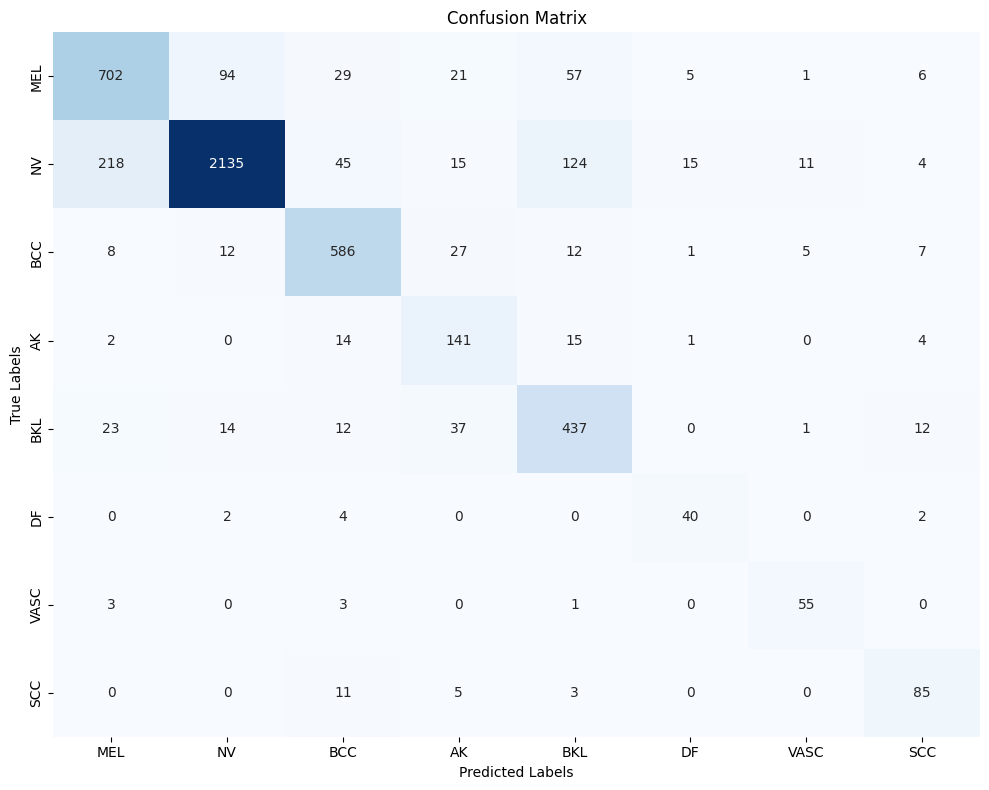

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=true_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=[labels[i] for i in true_classes],
            yticklabels=[labels[i] for i in true_classes], cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

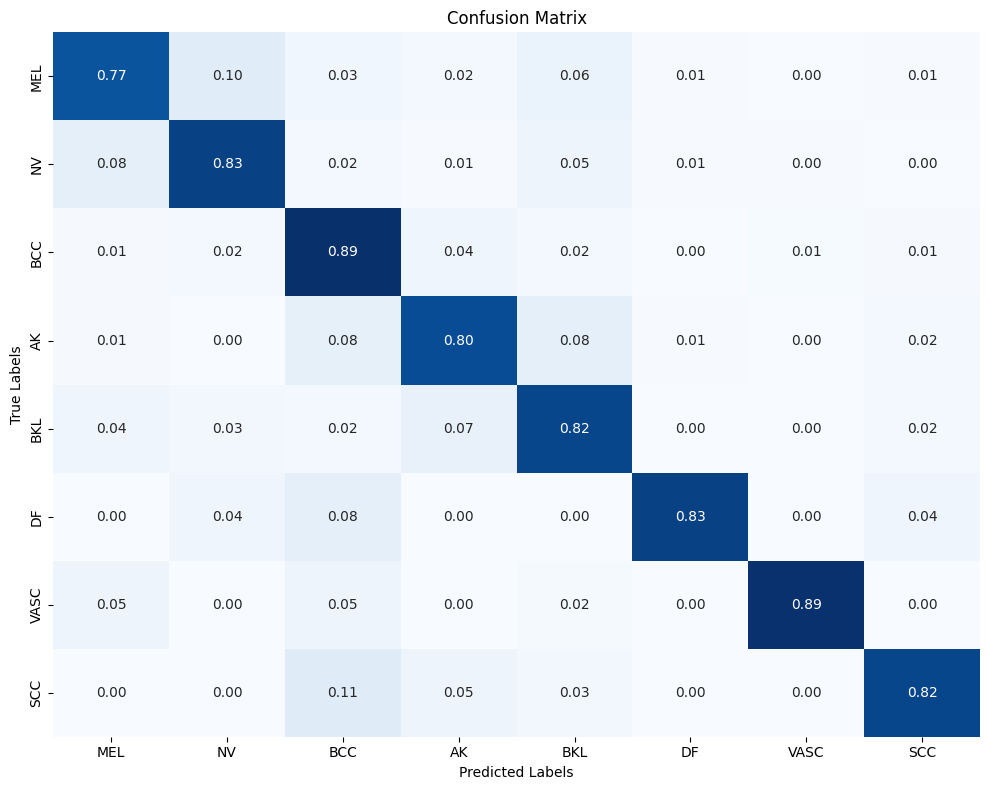

In [ ]:
# Normalized Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=true_classes, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", xticklabels=[labels[i] for i in true_classes],
            yticklabels=[labels[i] for i in true_classes], cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━

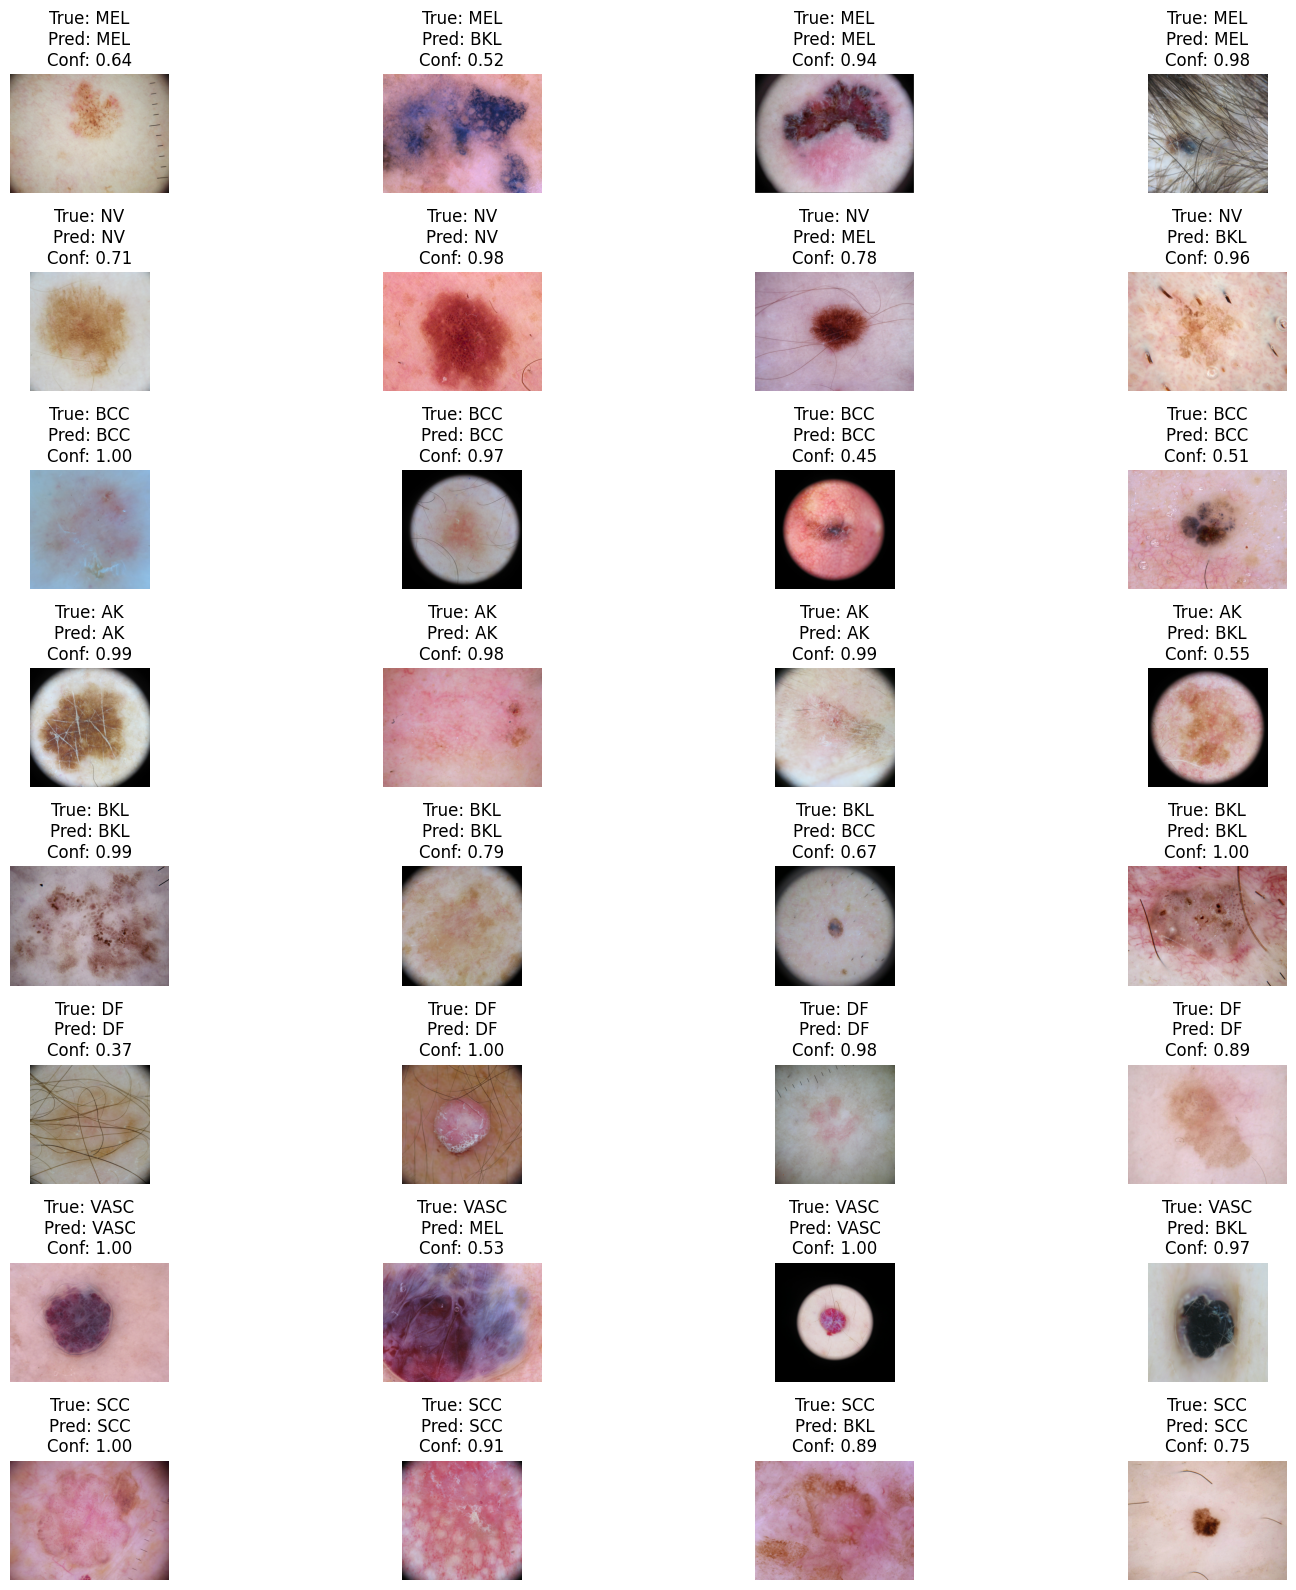

In [ ]:
# Dictionary to store images for each class
class_images = {i: [] for i in range(len(labels))}
# Group test images by their class
for path, label in zip(test_paths, test_labels):
    class_images[label].append(path)

num_samples_per_class = 4
selected_images = []
true_labels = []
for class_label, images in class_images.items():
    selected = random.sample(images, num_samples_per_class) if len(images) >= num_samples_per_class else images
    selected_images.extend(selected)
    true_labels.extend([class_label] * len(selected))

# Plotting
fig, axes = plt.subplots(8, 4, figsize=(16, 16))
axes = axes.flatten()
for i, (img_path, true_label) in enumerate(zip(selected_images, true_labels)):
    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.keras.applications.efficientnet.preprocess_input(img)

    # Expand dimensions for batch processing
    img_array = tf.expand_dims(img, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # Display the image and predictions
    axes[i].imshow(tf.image.decode_jpeg(tf.io.read_file(img_path)).numpy())
    axes[i].axis("off")
    axes[i].set_title(f"True: {labels[true_label]}\nPred: {labels[predicted_class]}\nConf: {confidence:.2f}")

plt.tight_layout()
plt.show()